In [1]:
import json
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn import datasets
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

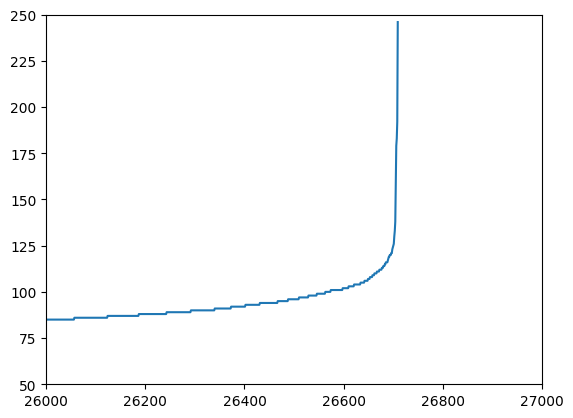

85


In [4]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.axis([26000, 27000, 50, 250])
plt.show()

print(newys[26000])
     

In [5]:
training_size = 23000
vocab_size = 2000
embedding_dim = 16
max_length = 85


training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
X_train = np.array(training_sentences)
X_test = np.array(testing_sentences)

In [7]:
text_vectorizer = keras.layers.TextVectorization(
    max_tokens=vocab_size, 
    standardize="lower_and_strip_punctuation",
    split="whitespace", 
    output_mode="count", 
    pad_to_max_tokens=True,
    #output_sequence_length=max_length
)

text_vectorizer.adapt(np.concatenate((X_train, X_test)), batch_size=512)

In [9]:
def create_model(text_vectorizer):
    return Sequential([
        layers.Input(shape=(1,), dtype="string", name="text"),
        text_vectorizer,
        layers.Embedding(vocab_size + 1, embedding_dim),
        layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1),
        layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1),
        layers.MaxPool1D(pool_size=4, strides=1),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ])

model = create_model(text_vectorizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 8000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 8000, 16)          32016     
                                                                 
 conv1d (Conv1D)             (None, 7996, 32)          2592      
                                                                 
 conv1d_1 (Conv1D)           (None, 7992, 64)          10304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7989, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 511296)            0

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, "binary_crossentropy", metrics=["accuracy"])

In [11]:
history = model.fit(training_sentences, training_labels, batch_size=256, epochs=10, validation_data=(testing_sentences, testing_labels))
gc.collect()

Epoch 1/10
90/90 [==============================] - 275s 3s/step - loss: 0.7451 - accuracy: 0.5486 - val_loss: 0.6786 - val_accuracy: 0.5705
Epoch 2/10
90/90 [==============================] - 276s 3s/step - loss: 0.6123 - accuracy: 0.6611 - val_loss: 0.5578 - val_accuracy: 0.7115
Epoch 3/10
90/90 [==============================] - 279s 3s/step - loss: 0.4874 - accuracy: 0.7653 - val_loss: 0.5269 - val_accuracy: 0.7296
Epoch 4/10
90/90 [==============================] - 278s 3s/step - loss: 0.4009 - accuracy: 0.8176 - val_loss: 0.5188 - val_accuracy: 0.7458
Epoch 5/10
90/90 [==============================] - 284s 3s/step - loss: 0.3269 - accuracy: 0.8577 - val_loss: 0.5502 - val_accuracy: 0.7339
Epoch 6/10
90/90 [==============================] - 276s 3s/step - loss: 0.2688 - accuracy: 0.8857 - val_loss: 0.6193 - val_accuracy: 0.7501
Epoch 7/10
90/90 [==============================] - 280s 3s/step - loss: 0.2264 - accuracy: 0.9066 - val_loss: 0.6407 - val_accuracy: 0.7460
Epoch 8/10
90

2281

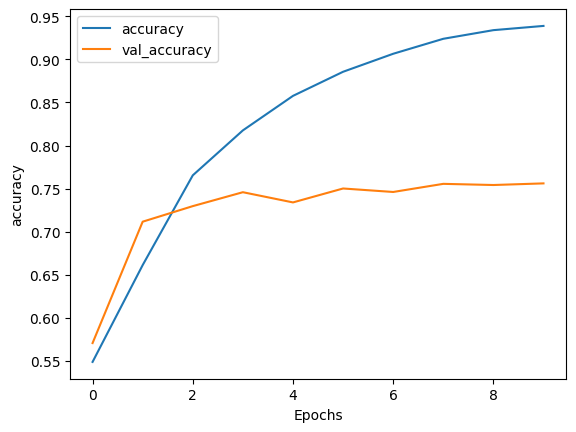

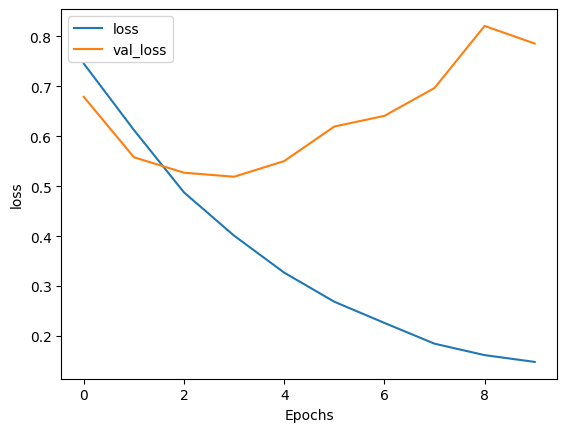

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [21]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

predictions = model.predict(test_sentences)
print(predictions[0])
print(predictions[1])
print(predictions[2])
print(predictions[3])

1/1 [==============================] - 0s 58ms/step
[1.186697e-05]
[0.31264213]
[0.00520777]
[1.]
